In [30]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
SSC_struct_rank_fil = "dat/bias/asd.asc.zmatch.rank.csv"
SSC_struct_rank_fil = "dat/bias/asc.norm.explevel.rank.tsv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
ssc_zmatch_graph_size, ssc_zmatch_stats, ssc_graphs = CircuitTrimming(g2, g)

In [32]:
SSC_struct_rank_fil = "dat/bias/asc.explevel.rank.tsv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
ssc_elevel_graph_size, ssc_elevel_stats, ssc_graphs = CircuitTrimming(g2, g)

In [33]:
SSC_struct_rank_fil = "dat/bias/asd.sparktada.zmatch.rank.csv"
SSC_struct_rank_fil = "dat/bias/sparktada.norm.explevel.rank.tsv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
tada_zmatch_graph_size, tada_zmatch_stats, tada_graphs = CircuitTrimming(g2, g)

In [34]:
SSC_struct_rank_fil = "dat/bias/sparktada.explevel.rank.tsv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
tada_elevel_graph_size, tada_elevel_stats, tada_graphs = CircuitTrimming(g2, g)

In [35]:
SSC_struct_rank_fil = "dat/bias/asd.sib.zmatch.rank.csv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
sib_zmatch_graph_size, sib_zmatch_stats, sib_graphs = CircuitTrimming(g2, g)

In [36]:
SSC_struct_rank_fil = "dat/bias/sib.explevel.rank.tsv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
sib_elevel_graph_size, sib_elevel_stats, sib_graphs = CircuitTrimming(g2, g)

In [37]:
rand_strs = pd.read_csv("dat/bias/sib.explevel.rank.tsv").sample(frac = 1).head(50)["STR"].values
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=rand_strs)
g2 = g.subgraph(top_nodes)
rand_graph_size, rand_stats, rand_graphs = CircuitTrimming(g2, g)

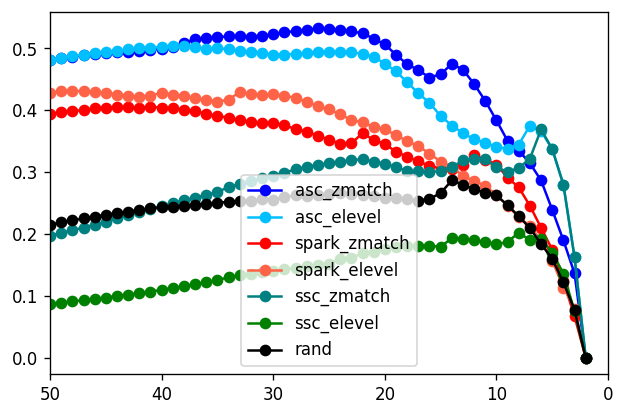

In [38]:
fig, ax = plt.subplots(dpi=120)
ax.plot(ssc_zmatch_graph_size, ssc_zmatch_stats, marker="o", color="blue", label="asc_zmatch")
ax.plot(ssc_elevel_graph_size, ssc_elevel_stats, marker="o", color="deepskyblue", label="asc_elevel")
ax.plot(tada_zmatch_graph_size, tada_zmatch_stats, marker="o", color="red", label="spark_zmatch")
ax.plot(tada_elevel_graph_size, tada_elevel_stats, marker="o", color="tomato", label="spark_elevel")
ax.plot(sib_zmatch_graph_size, sib_zmatch_stats, marker="o", color="teal", label="ssc_zmatch")
ax.plot(sib_elevel_graph_size, sib_elevel_stats, marker="o", color="green", label="ssc_elevel")
ax.plot(rand_graph_size, rand_stats, marker="o", color="black", label="rand")
ax.set_xlim(50, 0)  # decreasing time
plt.legend()

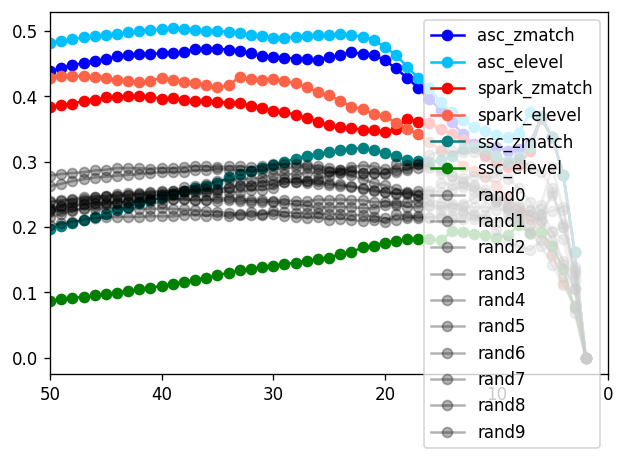

In [28]:
fig, ax = plt.subplots(dpi=120)
ax.plot(ssc_zmatch_graph_size, ssc_zmatch_stats, marker="o", color="blue", label="asc_zmatch")
ax.plot(ssc_elevel_graph_size, ssc_elevel_stats, marker="o", color="deepskyblue", label="asc_elevel")
ax.plot(tada_zmatch_graph_size, tada_zmatch_stats, marker="o", color="red", label="spark_zmatch")
ax.plot(tada_elevel_graph_size, tada_elevel_stats, marker="o", color="tomato", label="spark_elevel")
ax.plot(sib_zmatch_graph_size, sib_zmatch_stats, marker="o", color="teal", label="ssc_zmatch")
ax.plot(sib_elevel_graph_size, sib_elevel_stats, marker="o", color="green", label="ssc_elevel")
for i in range(10):
    rand_strs = pd.read_csv("dat/bias/sib.explevel.rank.tsv").sample(frac = 1).head(50)["STR"].values
    g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
    top_nodes = g.vs.select(label_in=rand_strs)
    g2 = g.subgraph(top_nodes)
    rand_graph_size, rand_stats, rand_graphs = CircuitTrimming(g2, g)
    ax.plot(rand_graph_size, rand_stats, marker="o", color="black", label="rand%d"%i, alpha=0.3)
ax.set_xlim(50, 0)  # decreasing time
plt.legend()
plt.show()